**Sprint 5: Model Improvement**
**Goal:** Improve model accuracy and optimize their parameters.

**Tasks:**

1. **Hyperparameter Optimization**

   * Use GridSearchCV or RandomizedSearchCV to find the best model parameters.

2. **Adding Additional Features**

   * Add new features, such as the average wind speed over the past 12 hours.

3. **Comparing Models with Enhanced Features**

   * Retrain all models with the new features and compare the results.

4. **Visualizing Improved Results**

   * Create an interactive graph showing the improvement in accuracy.

### We resolve paths and import packages

In [1]:
# Just pick the best model you want.
from tomodachi_core.models.weather_impact_model.tomodachi_model import TomodachiModel
from tomodachi_core.tomodachi.services import PandasService
from config_loader import load_config
import os
import pathlib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import numpy as np
# get curr dir
current_dir = os.getcwd()

# find the root using patlihb
root_dir = pathlib.Path(current_dir).parents[0].resolve()

# path to the config
config_path = (root_dir / "tomodachi_core" / "config_development" / "config.py").resolve()

# load the config
config = load_config(config_path)

# Grab the CSV_PATH
CSV_PATH = config.SAVE_TO_PATH

# Finally, we have to combine the path
CSV_PATH = (root_dir / CSV_PATH).resolve()

# Create PandasService
pandas_service = PandasService(str(CSV_PATH))

# load the data
df = pandas_service.load_csv_data()

Path C:\Users\Lenovo\Desktop\python_app\tuuleenergia_tomodachi exists.


### Function to create Pipeline

In [3]:
# We need this function to build multiple models
def create_pipeline(preprocessor, model_name, regressor):
    """
    Create a pipeline that uses the preprocessor and a model from tomodachi_models.

    Args:
        preprocessor: The preprocessor (e.g. ColumnTransformer)
        model_name: The key name of the model from tomodachi_models
        tomodachi_models: Dictionary of trained models (tomodachi_model.models)

    Returns:
        Pipeline
    """
    try:
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("regressor", regressor)
        ])
        return pipeline
    except KeyError as e:
        raise ValueError(f"Model '{model_name}' not found in tomodachi_models.") from e


### Define features & Create model

In [5]:
df_experiment_8 = df.copy()
df_experiment_8["Hour_of_Day_sin"] = np.sin(2 * np.pi * df_experiment_8["Hour_of_Day"] / 24)
df_experiment_8["Hour_of_Day_cos"] = np.cos(2 * np.pi * df_experiment_8["Hour_of_Day"] / 24)

df_experiment_8 = df_experiment_8.drop(columns=["Hour_of_Day"])

df_experiment_8["Power_Output"] = df_experiment_8["Power_Output"].shift(-1)
df_experiment_8["Wind_Speed_12h_avg"] = df_experiment_8["Wind_Speed"].rolling(window=12, min_periods=1).mean()
df_experiment_8["Wind_Gust_Diff"] = df_experiment_8["Wind_Gust"] - df_experiment_8["Wind_Speed"]
df_experiment_8["Radiation_Lag1"] = df_experiment_8["Solar_Radiation"].shift(1)

X_experiment_8 = df_experiment_8.drop(columns=["Power_Output", "Precipitation_Unit", "Timestamp"])
X_experiment_8 = X_experiment_8.dropna()

y_experiment_8 = df_experiment_8["Power_Output"]
y_experiment_8 = y_experiment_8.dropna()

X_experiment_8_train, X_experiment_8_test, y_experiment_8_train, y_experiment_8_test = train_test_split(
    X_experiment_8, y_experiment_8,
    test_size=0.2,
)


# OneHotEncoding features:
cat_features = ["Day_of_Week", "Month"]
num_features = [col for col in X_experiment_8.columns if col not in cat_features]


# Preprocessor
preprocessor_experiment_8 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

tomodachi_model = TomodachiModel()


### Create PIPELINES

In [8]:
pipeline_lr = create_pipeline(
    preprocessor_experiment_8,
    "lr",
    regressor=tomodachi_model.linear_model.model
)

In [9]:
pipeline_gr = create_pipeline(
    preprocessor_experiment_8,
    "gb",
    regressor=tomodachi_model.gradient_model.model
)

In [10]:
pipeline_rf = create_pipeline(
    preprocessor_experiment_8,
    "rf",
    regressor=tomodachi_model.forest_model.model
)

In [15]:
pipeline_xgb = create_pipeline(
    preprocessor_experiment_8,
    "xgb",
    regressor=tomodachi_model.xgboost_model.model
)

### Fit the models before we PREDICT

In [16]:
# Now we have to fit them all
pipeline_lr.fit(X_experiment_8_train, y_experiment_8_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Wind_Speed', 'Wind_Gust',
                                                   'Wind_Direction',
                                                   'Temperature', 'Humidity',
                                                   'Precipitation', 'Pressure',
                                                   'Cloud_Cover',
                                                   'Solar_Radiation',
                                                   'Wind_Speed_Squared',
                                                   'Wind_Speed_Cubed',
                                                   'Hour_of_Day_sin',
                                                   'Hour_of_Day_cos',
                                                   'Wind_Speed_12h_avg',
                                                   'Wind_Gust_Diff',
                                                   'Radiation_Lag1']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Day_of_Week', 'Month'])])),
                ('regressor', LinearRegression())])

In [17]:
pipeline_gr.fit(X_experiment_8_train, y_experiment_8_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Wind_Speed', 'Wind_Gust',
                                                   'Wind_Direction',
                                                   'Temperature', 'Humidity',
                                                   'Precipitation', 'Pressure',
                                                   'Cloud_Cover',
                                                   'Solar_Radiation',
                                                   'Wind_Speed_Squared',
                                                   'Wind_Speed_Cubed',
                                                   'Hour_of_Day_sin',
                                                   'Hour_of_Day_cos',
                                                   'Wind_Speed_12h_avg',
                                                   'Wind_Gust_Diff',
                                                   'Radiation_Lag1']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Day_of_Week', 'Month'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [18]:
pipeline_xgb.fit(X_experiment_8_train, y_experiment_8_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Wind_Speed', 'Wind_Gust',
                                                   'Wind_Direction',
                                                   'Temperature', 'Humidity',
                                                   'Precipitation', 'Pressure',
                                                   'Cloud_Cover',
                                                   'Solar_Radiation',
                                                   'Wind_Speed_Squared',
                                                   'Wind_Speed_Cubed',
                                                   'Hour_of_Day_sin',
                                                   'Hour_of_Day_cos',
                                                   'Wind_Speed_12h_avg',
                                                   'Wind_Gust_Diff',
                                                   'Radiation_Lag1']),
                                                 ('...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [19]:
pipeline_rf.fit(X_experiment_8_train, y_experiment_8_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Wind_Speed', 'Wind_Gust',
                                                   'Wind_Direction',
                                                   'Temperature', 'Humidity',
                                                   'Precipitation', 'Pressure',
                                                   'Cloud_Cover',
                                                   'Solar_Radiation',
                                                   'Wind_Speed_Squared',
                                                   'Wind_Speed_Cubed',
                                                   'Hour_of_Day_sin',
                                                   'Hour_of_Day_cos',
                                                   'Wind_Speed_12h_avg',
                                                   'Wind_Gust_Diff',
                                                   'Radiation_Lag1']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Day_of_Week', 'Month'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

### Print some X-s and y-s

In [20]:
X_experiment_8_train

,Wind_Speed,Wind_Gust,Wind_Direction,Temperature,Humidity,Precipitation,Pressure,Cloud_Cover,Solar_Radiation,Day_of_Week,Month,Wind_Speed_Squared,Wind_Speed_Cubed,Hour_of_Day_sin,Hour_of_Day_cos,Wind_Speed_12h_avg,Wind_Gust_Diff,Radiation_Lag1
12993,19.055279,20.988805,212.0,13.724691,65.258692,1.823672,974.106236,42.724675,956.949500,4.0,6.0,363.103674,6919.041982,0.707107,-0.707107,12.748165,1.933525,715.439615
21562,1.138726,1.641884,325.0,11.697011,62.057925,5.308838,952.549388,13.497992,193.754278,4.0,6.0,1.296698,1.476584,0.500000,-0.866025,12.127376,0.503157,903.874066
6328,5.702624,8.910020,133.0,8.151398,81.661447,6.627926,972.507482,73.204766,573.930154,6.0,9.0,32.519918,185.448862,-0.866025,-0.500000,12.218989,3.207396,295.451465
13205,11.994570,26.699423,174.0,20.156498,48.231479,3.781736,993.152444,58.520296,432.376140,6.0,7.0,542.244312,12626.776924,0.965926,0.258819,12.889367,14.704854,425.279820
24044,20.914272,21.467701,34.0,6.337783,71.465276,9.565834,989.237063,30.129635,500.575586,2.0,9.0,437.406773,9148.044216,-0.866025,0.500000,14.812366,0.553429,860.560254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,9.178073,10.329131,152.0,10.097258,65.990029,7.885877,1030.663019,80.432074,528.932896,3.0,10.0,84.237031,773.133655,-0.500000,0.866025,8.601780,1.151057,608.669335
5756,6.607061,9.238136,268.0,15.296674,53.189539,3.987106,1040.185530,30.187368,28.489265,3.0,8.0,43.653256,288.419729,-0.866025,0.500000,13.492694,2.631075,818.884716
14399,8.387740,12.634138,286.0,21.978332,52.174755,9.189127,955.280560,50.718956,794.562256,6.0,8.0,70.354185,590.112624,-0.258819,0.965926,12.940380,4.246397,472.524701
29963,8.441522,9.516245,120.0,11.614485,54.792547,1.048105,1024.954119,35.499064,576.205660,4.0,6.0,71.259287,601.536810,0.258819,-0.965926,10.034834,1.074723,547.873016


In [21]:
X_experiment_8_test

,Wind_Speed,Wind_Gust,Wind_Direction,Temperature,Humidity,Precipitation,Pressure,Cloud_Cover,Solar_Radiation,Day_of_Week,Month,Wind_Speed_Squared,Wind_Speed_Cubed,Hour_of_Day_sin,Hour_of_Day_cos,Wind_Speed_12h_avg,Wind_Gust_Diff,Radiation_Lag1
601,-22.590497,22.975351,6.0,-11.480051,86.512835,9.667723,1037.818050,99.678034,34.172715,6.0,1.0,510.330546,11528.620583,2.588190e-01,0.965926,5.658432,45.565848,680.875434
10471,21.886925,22.046147,45.0,6.804910,77.368939,7.950640,1044.074788,96.046840,460.602127,4.0,3.0,479.037483,10484.657434,9.659258e-01,-0.258819,11.250227,0.159223,885.175505
22858,9.043102,9.176045,199.0,17.583806,56.628372,7.792900,1010.082891,30.185270,172.999460,2.0,8.0,81.777686,739.523920,5.000000e-01,-0.866025,15.347583,0.132943,245.097062
1883,6.468695,7.243913,215.0,5.746089,79.956229,7.822170,985.727295,65.900092,540.549170,3.0,3.0,41.844019,270.676206,2.588190e-01,-0.965926,9.618524,0.775218,323.983938
3639,11.132185,14.248683,58.0,14.006840,65.679107,5.358946,960.350394,21.045457,953.424262,6.0,5.0,123.925535,1379.561936,-7.071068e-01,-0.707107,12.761992,3.116499,112.508931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,21.620194,22.515923,317.0,18.249181,54.741786,4.438935,1033.616595,30.528442,883.391257,5.0,7.0,467.432773,10105.987076,-9.659258e-01,-0.258819,11.646461,0.895730,855.518743
29429,22.940038,25.357832,111.0,9.080915,50.748420,7.126931,1036.649563,95.568546,940.025221,3.0,5.0,526.245347,12072.088292,9.659258e-01,0.258819,13.656670,2.417794,303.907074
19304,11.994570,6.343163,108.0,12.752967,62.838674,0.787288,1010.237084,86.629668,844.848708,1.0,3.0,1.874687,2.566806,8.660254e-01,-0.500000,16.106679,-5.651407,953.918821
23712,6.154918,9.313306,62.0,11.961518,72.687399,3.055550,1046.653931,98.377840,606.097432,3.0,9.0,37.883017,233.166867,0.000000e+00,1.000000,14.716025,3.158388,500.575586


In [22]:
y_experiment_8_train

12992     623.943592
21561     391.089717
6327       34.725897
13204    1290.548301
24043     391.089717
            ...     
7269       81.204045
5755      -33.723906
14398      74.602819
29962      84.298746
6614      145.399241
Name: Power_Output, Length: 23999, dtype: float64

In [23]:
y_experiment_8_test

600      1130.315050
10470    1084.903775
22857      96.998332
1882      -38.888637
3638      115.659498
            ...     
4792      994.501874
29428    1224.072829
19303    -119.821277
23711      56.726944
21899     391.089717
Name: Power_Output, Length: 6000, dtype: float64

### Log the RMSE & R2

In [27]:
preds = pipeline_lr.predict(X_experiment_8_test) # LinearRegression

score = r2_score(y_experiment_8_test, preds)
print(f"Test R2 score: {score:.4f}")

Test R2 score: 0.9364


In [26]:
preds = pipeline_gr.predict(X_experiment_8_test) # Gradient Boosting

score = r2_score(y_experiment_8_test, preds)
print(f"Test R2 score: {score:.4f}")

Test R2 score: 0.9355


In [28]:
preds = pipeline_rf.predict(X_experiment_8_test) # Random Forest

score = r2_score(y_experiment_8_test, preds)
print(f"Test R2 score: {score:.4f}")

Test R2 score: 0.9291


In [29]:
preds = pipeline_xgb.predict(X_experiment_8_test) # XGBoost

score = r2_score(y_experiment_8_test, preds)
print(f"Test R2 score: {score:.4f}")

Test R2 score: 0.9263


### Apply hyper-parameter training

#### XGBoost

In [57]:
param_grid_lr = {
    'regressor__fit_intercept': [True, False],
}

param_grid_gr = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.01, 0.05],
    # 'regressor__subsample': [0.6, 0.8], 
    # 'regressor__min_samples_split': [2, 5, 10],     
    # 'regressor__min_samples_leaf': [1, 2, 4],       
    #'regressor__max_features': ['auto', 'sqrt', 'log2'],
}

param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    # 'regressor__max_features': ['auto', 'sqrt'],
    # 'regressor__min_samples_split': [2, 5, 10],
    # 'regressor__min_samples_leaf': [1, 2, 4],
    # 'regressor__bootstrap': [True, False], 
}

In [42]:
param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.7, 1.0],
}

grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=5,             
    scoring="r2",     
    n_jobs=-1,        
    verbose=2,
)

grid_search_xgb.fit(X_experiment_8_train, y_experiment_8_train)

# Evaluate
print("Best params:", grid_search_xgb.best_params_)
print("Best CV R2:", grid_search_xgb.best_score_)

# Test
best_model_xgb = grid_search_xgb.best_estimator_
preds_xgb = best_model_xgb.predict(X_experiment_8_test)
test_score_xgb = r2_score(y_experiment_8_test, preds_xgb)
print(f"Test R2 score: {test_score_xgb:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
Best CV R2: 0.9363923930183551
Test R2 score: 0.9352


In [45]:
# Do the same for LinearModel
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='r2', n_jobs=-1)
grid_search_lr.fit(X_experiment_8_train, y_experiment_8_train)

# Evaluate
print("Best params:", grid_search_lr.best_params_)
print("Best CV R2:", grid_search_lr.best_score_)

# Test
best_model_lr = grid_search_lr.best_estimator_
preds_lr = best_model_lr.predict(X_experiment_8_test)
test_score_lr = r2_score(y_experiment_8_test, preds_lr)
print(f"Test R2 score: {test_score_lr:.4f}")

Best params: {'regressor__fit_intercept': True}
Best CV R2: 0.9373112012311412
Test R2 score: 0.9364


In [53]:
# Do the same for Gradient Boost
grid_search_gb = GridSearchCV(pipeline_gr, param_grid_gr, cv=3, scoring='r2', n_jobs=-1)
grid_search_gb.fit(X_experiment_8_train, y_experiment_8_train)

# Evaluate
print("Best params:", grid_search_gb.best_params_)
print("Best CV R2:", grid_search_gb.best_score_)

# Test
best_model_gb = grid_search_gb.best_estimator_
preds_gb = best_model_gb.predict(X_experiment_8_test)
test_score_gb = r2_score(y_experiment_8_test, preds_gb)
print(f"Test R2 score: {test_score_gb:.4f}")

Best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Best CV R2: 0.9366552922265295
Test R2 score: 0.9356


In [58]:
# Do the same for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_experiment_8_train, y_experiment_8_train)

# Evaluate
print("Best params:", grid_search_rf.best_params_)
print("Best CV R2:", grid_search_rf.best_score_)

# Test
best_model_rf = grid_search_gb.best_estimator_
preds_rf = best_model_rf.predict(X_experiment_8_test)
test_score_rf = r2_score(y_experiment_8_test, preds_rf)
print(f"Test R2 score: {test_score_rf:.4f}")

Best params: {'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Best CV R2: 0.9363652367005382
Test R2 score: 0.9356


### Visualize

#### Random Forest

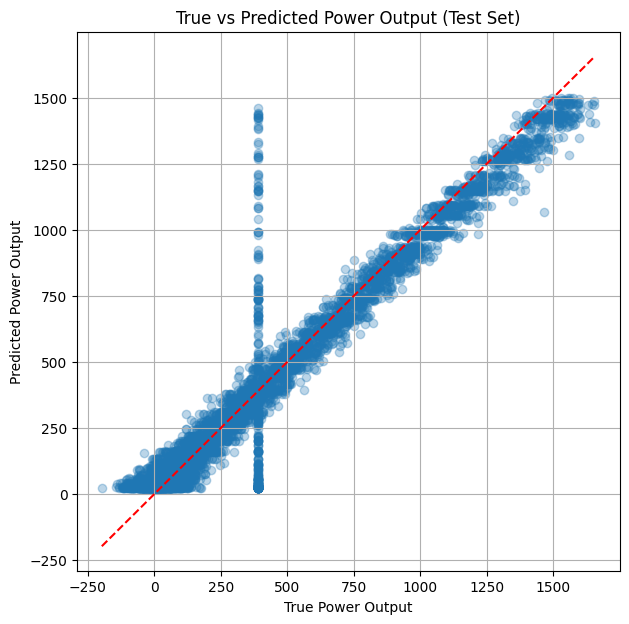

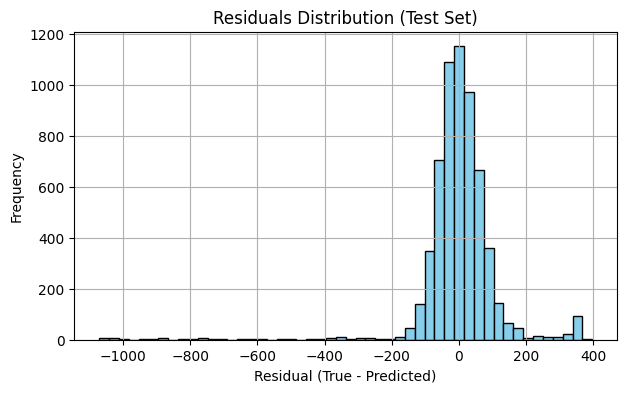

In [60]:
import matplotlib.pyplot as plt

# 1. True vs Predicted Power Output (Scatter Plot)
plt.figure(figsize=(7, 7))
plt.scatter(y_experiment_8_test, preds_rf, alpha=0.3)
plt.xlabel("True Power Output")
plt.ylabel("Predicted Power Output")
plt.title("True vs Predicted Power Output (Test Set)")
plt.plot([y_experiment_8_test.min(), y_experiment_8_test.max()],
         [y_experiment_8_test.min(), y_experiment_8_test.max()],
         'r--')
plt.grid(True)
plt.show()

# 2. Residuals Plot
residuals = y_experiment_8_test - preds_rf
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Test Set)")
plt.grid(True)
plt.show()

#### XGBoost

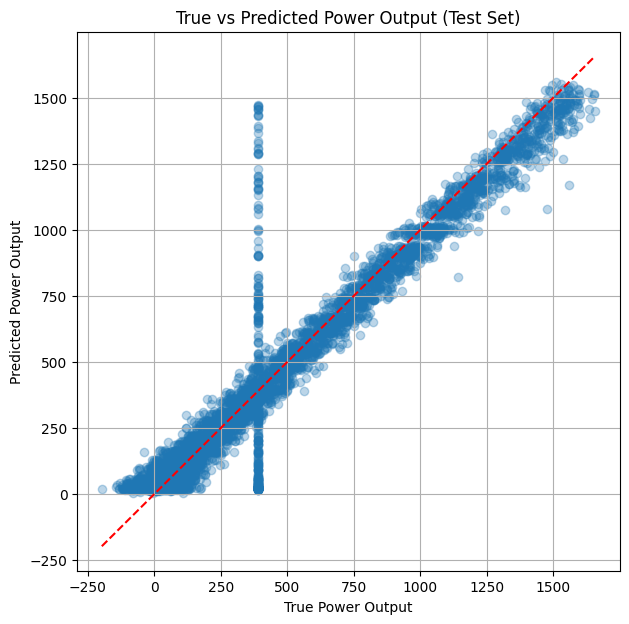

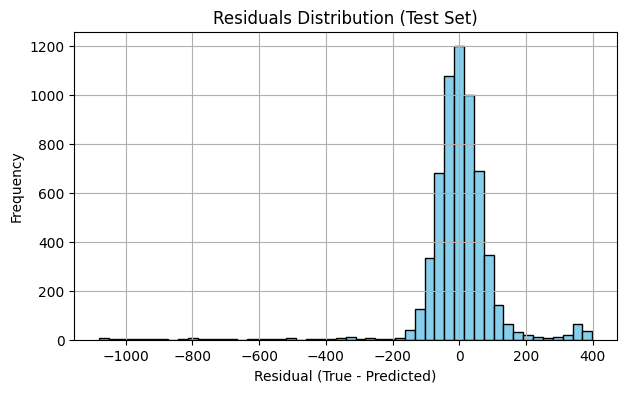

In [61]:
plt.figure(figsize=(7, 7))
plt.scatter(y_experiment_8_test, preds_xgb, alpha=0.3)
plt.xlabel("True Power Output")
plt.ylabel("Predicted Power Output")
plt.title("True vs Predicted Power Output (Test Set)")
plt.plot([y_experiment_8_test.min(), y_experiment_8_test.max()],
         [y_experiment_8_test.min(), y_experiment_8_test.max()],
         'r--')
plt.grid(True)
plt.show()

# 2. Residuals Plot
residuals = y_experiment_8_test - preds_xgb
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Test Set)")
plt.grid(True)
plt.show()

#### Gradient Boosting

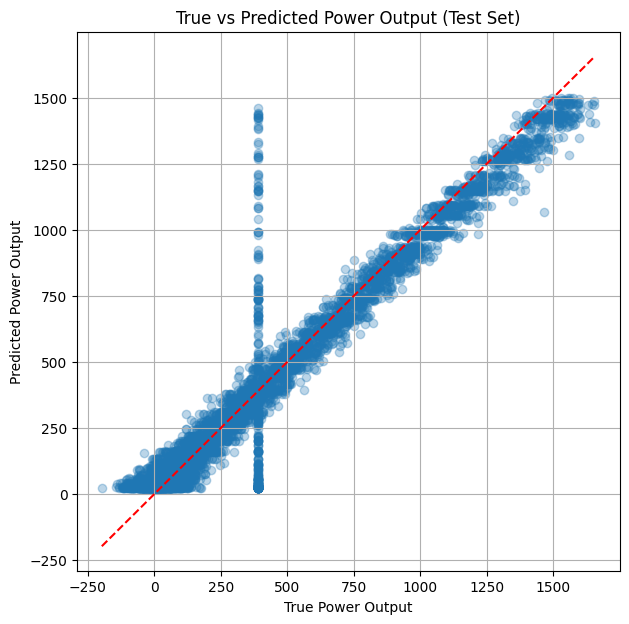

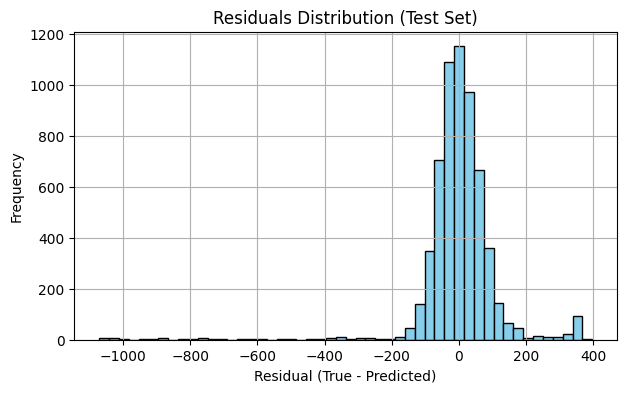

In [62]:
plt.figure(figsize=(7, 7))
plt.scatter(y_experiment_8_test, preds_gb, alpha=0.3)
plt.xlabel("True Power Output")
plt.ylabel("Predicted Power Output")
plt.title("True vs Predicted Power Output (Test Set)")
plt.plot([y_experiment_8_test.min(), y_experiment_8_test.max()],
         [y_experiment_8_test.min(), y_experiment_8_test.max()],
         'r--')
plt.grid(True)
plt.show()

# 2. Residuals Plot
residuals = y_experiment_8_test - preds_gb
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Test Set)")
plt.grid(True)
plt.show()

#### Linear Regression

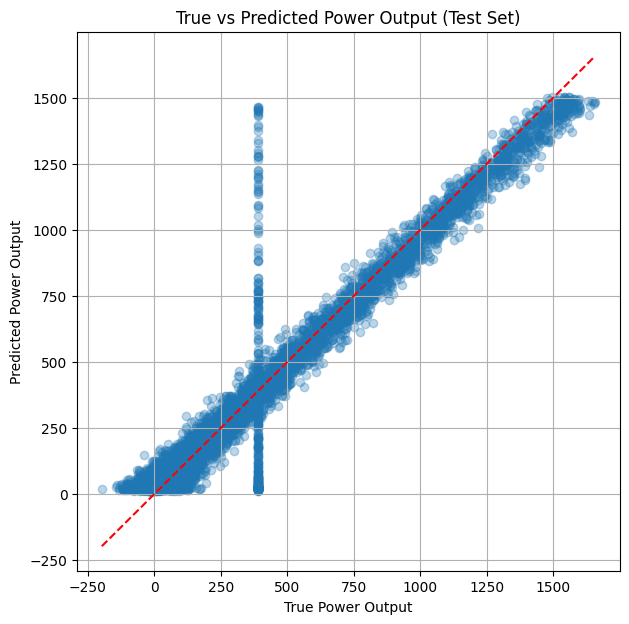

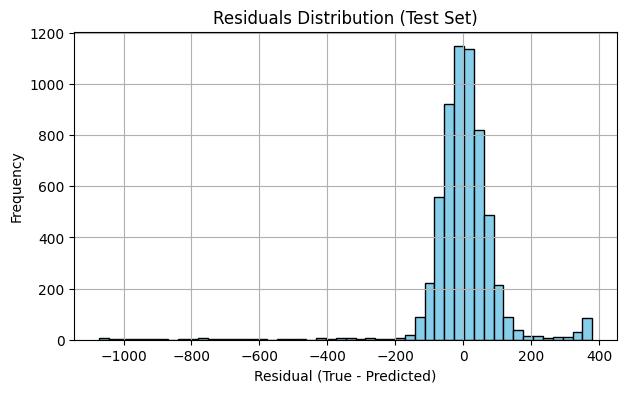

In [63]:
plt.figure(figsize=(7, 7))
plt.scatter(y_experiment_8_test, preds_lr, alpha=0.3)
plt.xlabel("True Power Output")
plt.ylabel("Predicted Power Output")
plt.title("True vs Predicted Power Output (Test Set)")
plt.plot([y_experiment_8_test.min(), y_experiment_8_test.max()],
         [y_experiment_8_test.min(), y_experiment_8_test.max()],
         'r--')
plt.grid(True)
plt.show()

# 2. Residuals Plot
residuals = y_experiment_8_test - preds_lr
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Test Set)")
plt.grid(True)
plt.show()

## Saving to a path & Deployment

In [65]:
import joblib

path_to_save = (root_dir / "shared" / "data" / "export").resolve() 


our_models = {
    "xgb": (best_model_xgb, f"{path_to_save}/xgb_model.joblib"),
    "gb": (best_model_gb, f"{path_to_save}/gb_model.joblib"),
    "lr": (best_model_lr, f"{path_to_save}/lr_model.joblib"),
    "rf": (best_model_rf, f"{path_to_save}/rf_model.joblib")
}

for _, (model, path) in our_models.items():
    joblib.dump(model, path)